In [10]:
# pip install pandas
# pip install numpy
# pip install torch

In [11]:
import random
import pandas as pd
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
#import torchvision.datasets as dset
#import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

## 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

## 한글 폰트 설정한글 폰트 설정
plt.rcParams["font.family"] = 'Malgun Gothic'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'matplotlib'

# Model &  Train

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 3),
            nn.ReLU()  
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 4),
            nn.Sigmoid(),
            nn.Linear(4,input_dim),
            nn.Linear(input_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    def get_codes(self, x): #Input의 Latent Vector를 추출
        return self.encoder(x)  

In [ ]:
def train_model(train_sdata, valid_sdata,test_sdata, model, 
                criterion, optimizer, num_epochs, batch_size):

    best_test_loss = 99999999
    
    x_train=torch.utils.data.DataLoader(dataset=train_sdata, batch_size=batch_size, 
                                        shuffle=False)
    x_valid=torch.utils.data.DataLoader(dataset=valid_sdata, batch_size=batch_size, 
                                        shuffle=False)
    x_test=torch.utils.data.DataLoader(dataset=test_sdata, batch_size=batch_size, 
                                       shuffle=False)
    
    train_loss, valid_loss,test_loss = [], [], []
    
    for epoch in range(num_epochs):
        
        model.train()
        for inputs in x_train:

            inputs=inputs.float().to(device)

            optimizer.zero_grad()

            #Forward 
            train_enco,outputs=model(inputs)
            trainloss=criterion(outputs, inputs)

            # Backward and optimize
            trainloss.backward()
            optimizer.step()
            
        train_loss.append(trainloss.detach())


        model.eval()
        for valid_inputs in x_valid:

            valid_inputs = valid_inputs.float().to(device)

            valid_enco, valid_outputs=model(valid_inputs)
            validloss=criterion(valid_outputs, valid_inputs)
            
        valid_loss.append(validloss.detach())
        
        for test_inputs in x_test:

            test_inputs = test_inputs.float().to(device)

            test_enco, test_outputs=model(test_inputs)
            testloss=criterion(test_outputs, test_inputs)
            
        test_loss.append(testloss.detach())


        if (epoch % 10 ==0) or (epoch == num_epochs-1) :
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('trainloss : {:.5f}, validloss.data : {:.5f},testiloss :  {:.5f}'.format(trainloss.data,validloss.data,testloss.data))
                
    print('---'*30)

    np_train_loss=np.array(train_loss)
    np_test_loss=np.array(test_loss)
    minus=np_train_loss-np_test_loss
    
    mpl.rcParams['figure.figsize'] = (10, 8)
    mpl.rcParams['axes.grid'] = False
    
    plt.plot(range(num_epochs),train_loss,label='Train')
    plt.plot(range(num_epochs),valid_loss,label='Valid')
    plt.plot(range(num_epochs),test_loss,label='Test')
    plt.plot(range(num_epochs),minus,linestyle='--',label='Difference')
    plt.legend()
    plt.title('Error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    print('---'*30)
    
    return model,best_test_loss, train_loss, valid_loss,test_loss

# 차압 포함 & 0값 포함

In [ ]:
df = pd.read_excel('SK_MAGIC_APM_DATA.xlsx')
df_five = df.loc[:,['토출 공기 온도', '토출 공기 압력', '내부 오일 압력','차압']]

train_data=df_five.iloc[:1001]
test_data=df_five.iloc[1001:]

display(train_data.head())

## 한글 폰트 설정한글 폰트 설정
plt.rcParams["font.family"] = 'Malgun Gothic'


#Standard data
train_idx, valid_idx=train_test_split( train_data,test_size=0.2, random_state=10, shuffle=False)

minmax=MinMaxScaler()
train_sdata=minmax.fit_transform(train_idx)
valid_sdata=minmax.transform(valid_idx)
test_sdata=minmax.transform(test_data)

#시각화
pd.DataFrame(train_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력','차압']).plot()
pd.DataFrame(valid_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력','차압']).plot()
pd.DataFrame(test_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력','차압']).plot()


,토출 공기 온도,토출 공기 압력,내부 오일 압력,차압
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


<Axes: >

Epoch 0/299
trainloss : 0.57184, validloss.data : 0.44421,testiloss :  0.33358
Epoch 10/299
trainloss : 0.30574, validloss.data : 0.20197,testiloss :  0.10805
Epoch 20/299
trainloss : 0.23459, validloss.data : 0.15391,testiloss :  0.05657
Epoch 30/299
trainloss : 0.20585, validloss.data : 0.14481,testiloss :  0.05366
Epoch 40/299
trainloss : 0.18712, validloss.data : 0.13830,testiloss :  0.05178
Epoch 50/299
trainloss : 0.15998, validloss.data : 0.12289,testiloss :  0.03896
Epoch 60/299
trainloss : 0.11738, validloss.data : 0.09787,testiloss :  0.01659
Epoch 70/299
trainloss : 0.08275, validloss.data : 0.08409,testiloss :  0.00344
Epoch 80/299
trainloss : 0.06926, validloss.data : 0.08527,testiloss :  0.00099
Epoch 90/299
trainloss : 0.06313, validloss.data : 0.08770,testiloss :  0.00082
Epoch 100/299
trainloss : 0.05891, validloss.data : 0.08958,testiloss :  0.00098
Epoch 110/299
trainloss : 0.05567, validloss.data : 0.09140,testiloss :  0.00134
Epoch 120/299
trainloss : 0.05328, vali

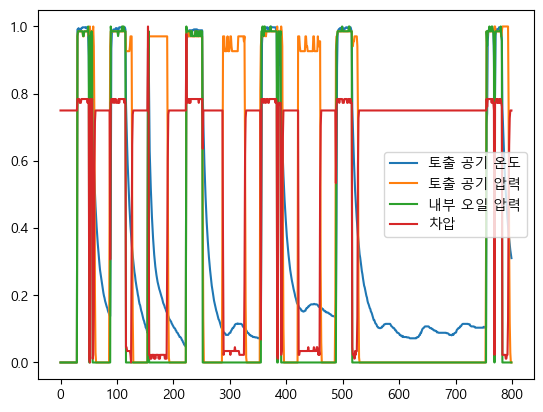

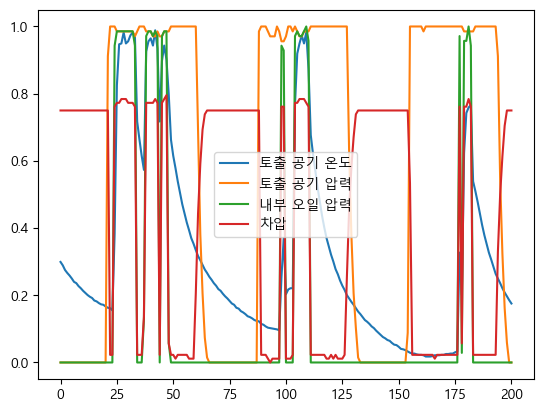

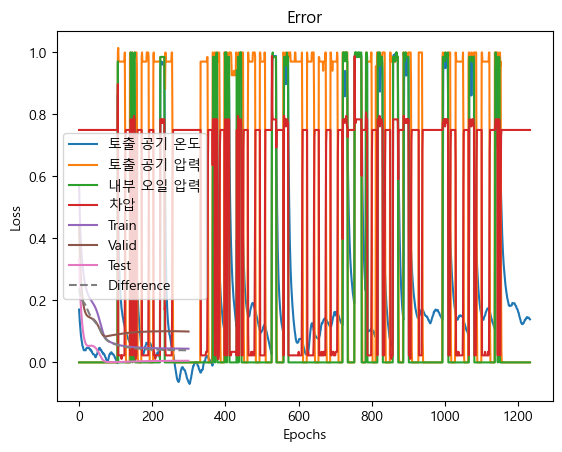

------------------------------------------------------------------------------------------


In [ ]:
input_dim = train_sdata.shape[1]

batch_size = 67
num_epochs = 300
lr = 0.001

model = AutoEncoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer= optim.Adam(model.parameters(),lr = lr)

## model train
model,best_test_loss, train_loss, valid_loss,test_loss = train_model(train_sdata, valid_sdata, test_sdata, model,criterion, optimizer, num_epochs, batch_size)

# 차압 포함 & 0값 제거

In [ ]:
df_five = df.loc[:,['토출 공기 온도', '토출 공기 압력', '내부 오일 압력','차압']]

train_data=df_five.iloc[:1001]
test_data=df_five.iloc[1001:]

display(train_data.head())

print(df_five.shape)
zero=df_five[(df_five['토출 공기 온도']==0) & (df_five['토출 공기 압력']==0) &  (df_five['내부 오일 압력']==0)].index
print(len(zero))
zero_remove=df_five.drop(zero)
print(zero_remove.shape)
zero_remove=zero_remove.reset_index(drop=True)
display(zero_remove.head())


#Standard data
train_idx, valid_idx=train_test_split( train_data,test_size=0.2, random_state=10, shuffle=False)

minmax=MinMaxScaler()
train_sdata=minmax.fit_transform(train_idx)
valid_sdata=minmax.transform(valid_idx)
test_sdata=minmax.transform(test_data)

#시각화
pd.DataFrame(train_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력','차압']).plot()
pd.DataFrame(valid_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력','차압']).plot()
pd.DataFrame(test_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력','차압']).plot()

,토출 공기 온도,토출 공기 압력,내부 오일 압력,차압
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


(2234, 4)
32
(2202, 4)


,토출 공기 온도,토출 공기 압력,내부 오일 압력,차압
0,78.5,6.6,6.8,0.3
1,78.5,6.7,6.9,0.3
2,78.8,6.7,6.9,0.3
3,78.5,6.7,6.9,0.3
4,78.5,6.7,6.9,0.2


<Axes: >

Epoch 0/299
trainloss : 0.49512, validloss.data : 0.31404,testiloss :  0.20203
Epoch 10/299
trainloss : 0.28932, validloss.data : 0.17561,testiloss :  0.05761
Epoch 20/299
trainloss : 0.22778, validloss.data : 0.14909,testiloss :  0.04917
Epoch 30/299
trainloss : 0.20769, validloss.data : 0.14629,testiloss :  0.05775
Epoch 40/299
trainloss : 0.19753, validloss.data : 0.14059,testiloss :  0.05598
Epoch 50/299
trainloss : 0.18370, validloss.data : 0.12646,testiloss :  0.04483
Epoch 60/299
trainloss : 0.15851, validloss.data : 0.10299,testiloss :  0.02766
Epoch 70/299
trainloss : 0.12605, validloss.data : 0.08234,testiloss :  0.01261
Epoch 80/299
trainloss : 0.09940, validloss.data : 0.07643,testiloss :  0.00449
Epoch 90/299
trainloss : 0.08299, validloss.data : 0.07925,testiloss :  0.00145
Epoch 100/299
trainloss : 0.07153, validloss.data : 0.08235,testiloss :  0.00060
Epoch 110/299
trainloss : 0.06283, validloss.data : 0.08598,testiloss :  0.00075
Epoch 120/299
trainloss : 0.05656, vali

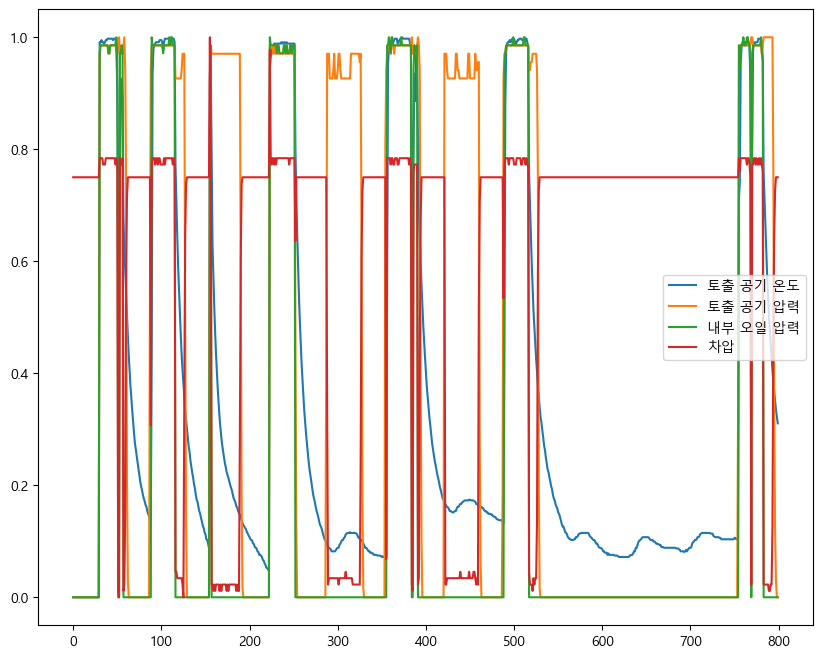

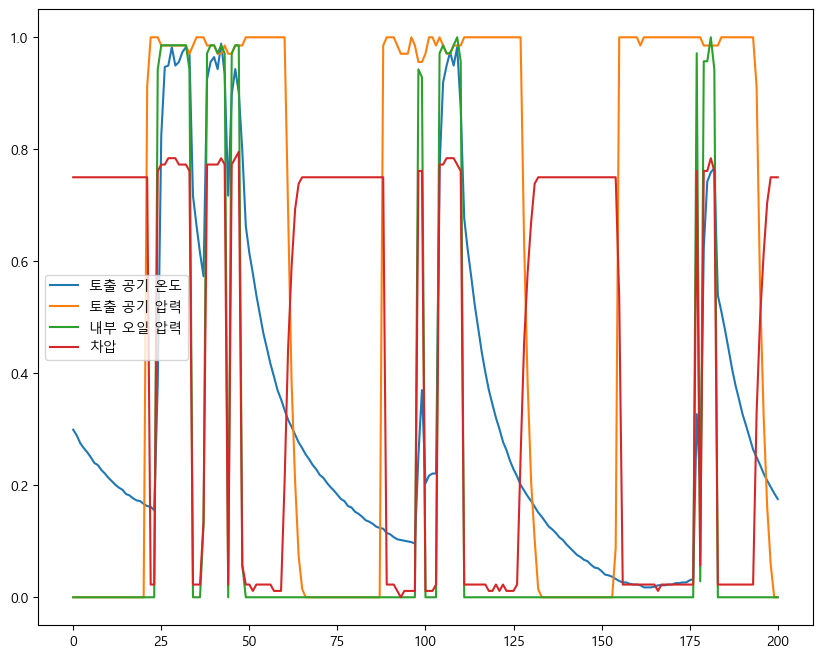

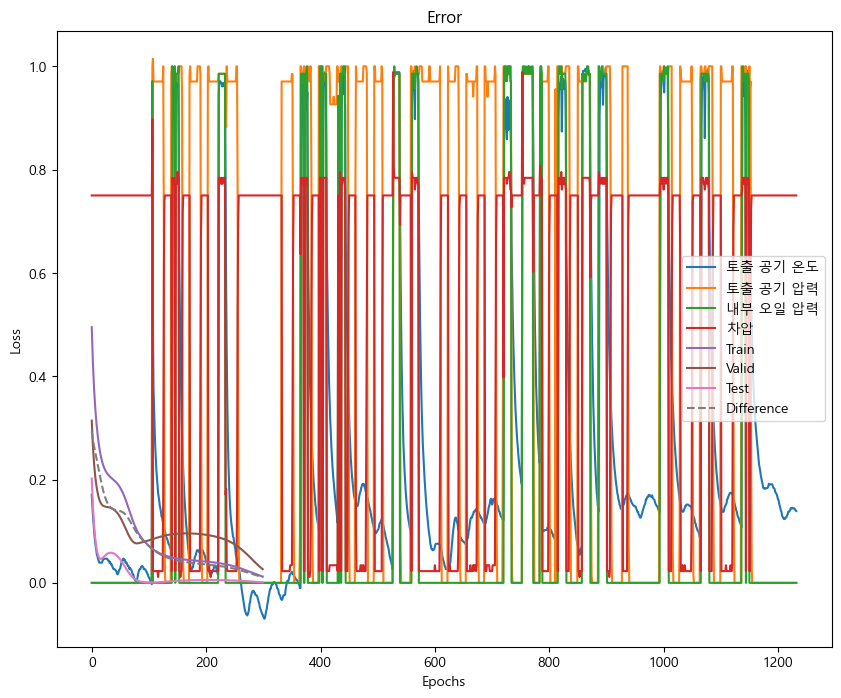

------------------------------------------------------------------------------------------


In [ ]:
input_dim = train_sdata.shape[1]

batch_size = 67
num_epochs = 300
lr = 0.001

model = AutoEncoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer= optim.Adam(model.parameters(),lr = lr)

## model train
model,best_test_loss, train_loss, valid_loss,test_loss = train_model(train_sdata, valid_sdata, test_sdata, model,criterion, optimizer, num_epochs, batch_size)

# 차압 제거 & 0값 포함

In [ ]:
df_five = df.loc[:,['토출 공기 온도', '토출 공기 압력', '내부 오일 압력']]

train_data=df_five.iloc[:1001]
test_data=df_five.iloc[1001:]

display(train_data.head())


#Standard data
train_idx, valid_idx=train_test_split( train_data,test_size=0.2, random_state=10, shuffle=False)

minmax=MinMaxScaler()
train_sdata=minmax.fit_transform(train_idx)
valid_sdata=minmax.transform(valid_idx)
test_sdata=minmax.transform(test_data)

#시각화
pd.DataFrame(train_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력']).plot()
pd.DataFrame(valid_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력']).plot()
pd.DataFrame(test_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력']).plot()


,토출 공기 온도,토출 공기 압력,내부 오일 압력
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


<Axes: >

Epoch 0/299
trainloss : 0.59689, validloss.data : 0.33234,testiloss :  0.05400
Epoch 10/299
trainloss : 0.38818, validloss.data : 0.16704,testiloss :  0.02687
Epoch 20/299
trainloss : 0.28000, validloss.data : 0.13680,testiloss :  0.05461
Epoch 30/299
trainloss : 0.24914, validloss.data : 0.13719,testiloss :  0.07823
Epoch 40/299
trainloss : 0.23974, validloss.data : 0.13228,testiloss :  0.08061
Epoch 50/299
trainloss : 0.22898, validloss.data : 0.12101,testiloss :  0.07580
Epoch 60/299
trainloss : 0.21083, validloss.data : 0.10392,testiloss :  0.06684
Epoch 70/299
trainloss : 0.18499, validloss.data : 0.08637,testiloss :  0.05464
Epoch 80/299
trainloss : 0.15580, validloss.data : 0.07385,testiloss :  0.04052
Epoch 90/299
trainloss : 0.12773, validloss.data : 0.06836,testiloss :  0.02667
Epoch 100/299
trainloss : 0.10145, validloss.data : 0.06752,testiloss :  0.01566
Epoch 110/299
trainloss : 0.07860, validloss.data : 0.06775,testiloss :  0.00768
Epoch 120/299
trainloss : 0.06033, vali

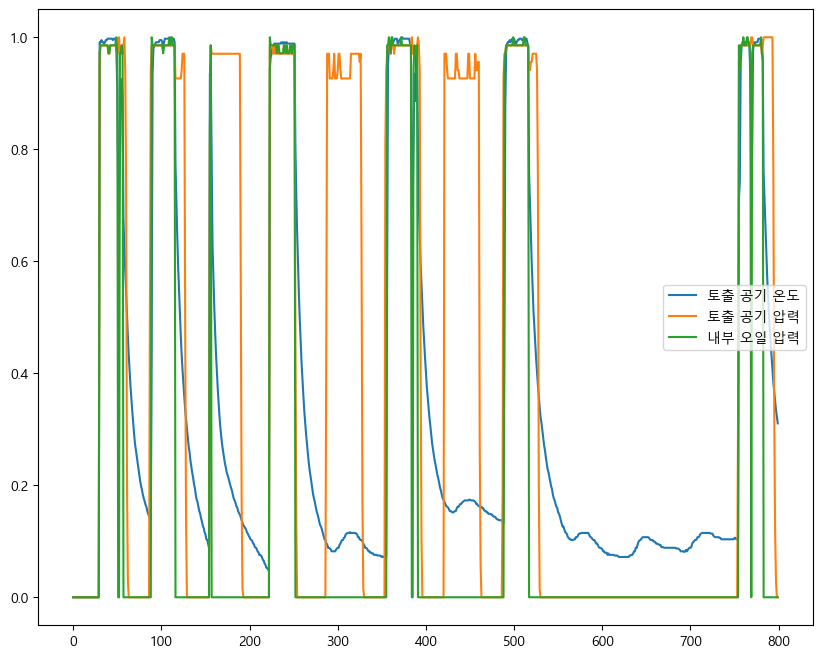

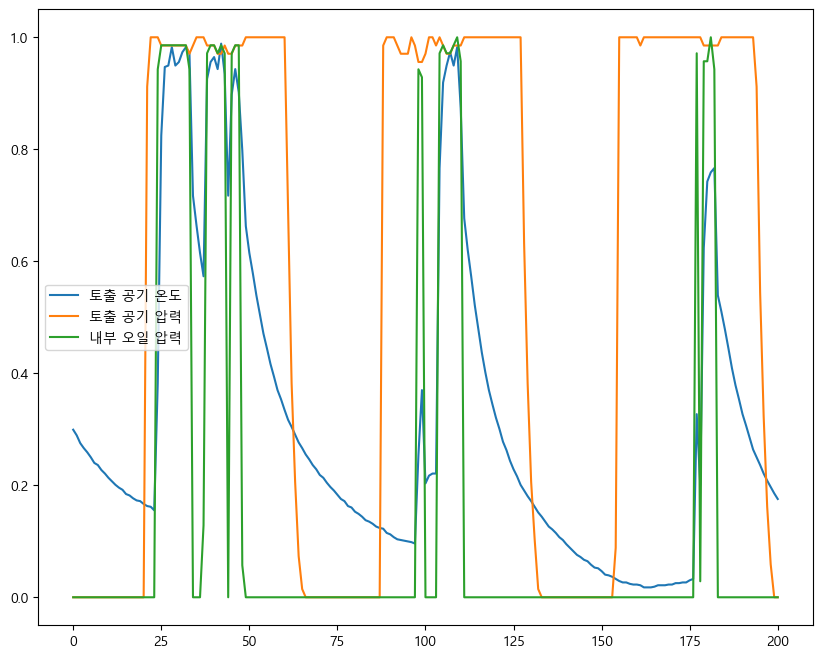

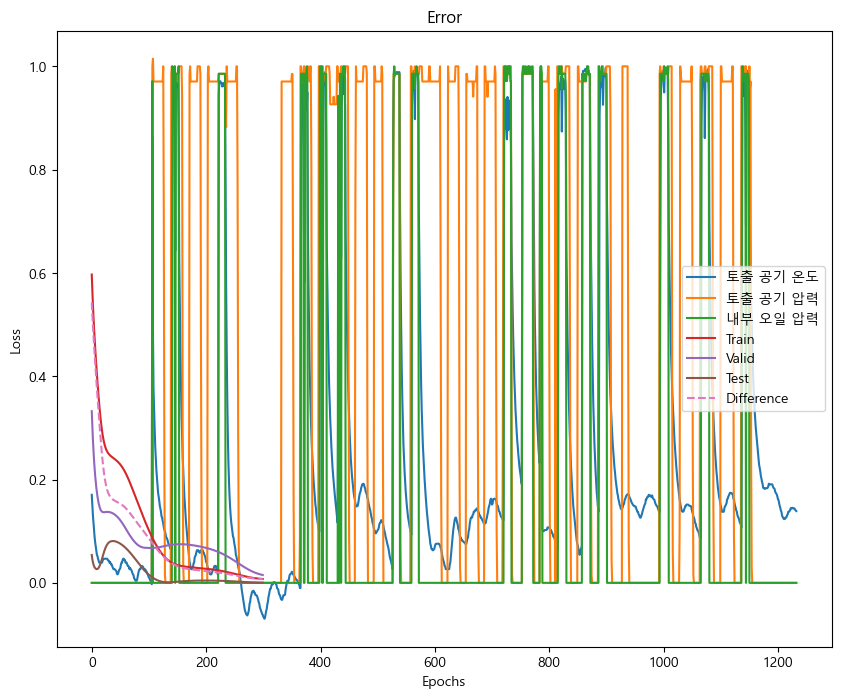

------------------------------------------------------------------------------------------


In [ ]:
input_dim = train_sdata.shape[1]

batch_size = 67
num_epochs = 300
lr = 0.001

model = AutoEncoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer= optim.Adam(model.parameters(),lr = lr)

## model train
model,best_test_loss, train_loss, valid_loss,test_loss = train_model(train_sdata, valid_sdata, test_sdata, model,criterion, optimizer, num_epochs, batch_size)

# 차압 제거 & 0값 제거

In [ ]:
df_five = df.loc[:,['토출 공기 온도', '토출 공기 압력', '내부 오일 압력']]

train_data=df_five.iloc[:1001]
test_data=df_five.iloc[1001:]

display(train_data.head())

print(df_five.shape)
zero=df_five[(df_five['토출 공기 온도']==0) & (df_five['토출 공기 압력']==0) &  (df_five['내부 오일 압력']==0)].index
print(len(zero))
zero_remove=df_five.drop(zero)
print(zero_remove.shape)
zero_remove=zero_remove.reset_index(drop=True)
display(zero_remove.head())


#Standard data
train_idx, valid_idx=train_test_split( train_data,test_size=0.2, random_state=10, shuffle=False)

minmax=MinMaxScaler()
train_sdata=minmax.fit_transform(train_idx)
valid_sdata=minmax.transform(valid_idx)
test_sdata=minmax.transform(test_data)

#시각화
pd.DataFrame(train_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력']).plot()
pd.DataFrame(valid_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력']).plot()
pd.DataFrame(test_sdata,columns=['토출 공기 온도','토출 공기 압력','내부 오일 압력']).plot()

,토출 공기 온도,토출 공기 압력,내부 오일 압력
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


(2234, 3)
32
(2202, 3)


,토출 공기 온도,토출 공기 압력,내부 오일 압력
0,78.5,6.6,6.8
1,78.5,6.7,6.9
2,78.8,6.7,6.9
3,78.5,6.7,6.9
4,78.5,6.7,6.9


<Axes: >

Epoch 0/299
trainloss : 0.83368, validloss.data : 0.39009,testiloss :  0.32719
Epoch 10/299
trainloss : 0.44093, validloss.data : 0.20172,testiloss :  0.08683
Epoch 20/299
trainloss : 0.30657, validloss.data : 0.15889,testiloss :  0.06014
Epoch 30/299
trainloss : 0.25582, validloss.data : 0.14585,testiloss :  0.07095
Epoch 40/299
trainloss : 0.23312, validloss.data : 0.14051,testiloss :  0.07900
Epoch 50/299
trainloss : 0.21137, validloss.data : 0.13516,testiloss :  0.07987
Epoch 60/299
trainloss : 0.17945, validloss.data : 0.12646,testiloss :  0.07444
Epoch 70/299
trainloss : 0.13476, validloss.data : 0.11322,testiloss :  0.06245
Epoch 80/299
trainloss : 0.08695, validloss.data : 0.09886,testiloss :  0.04689
Epoch 90/299
trainloss : 0.05496, validloss.data : 0.09025,testiloss :  0.03457
Epoch 100/299
trainloss : 0.04045, validloss.data : 0.08715,testiloss :  0.02591
Epoch 110/299
trainloss : 0.03381, validloss.data : 0.08612,testiloss :  0.01928
Epoch 120/299
trainloss : 0.03060, vali

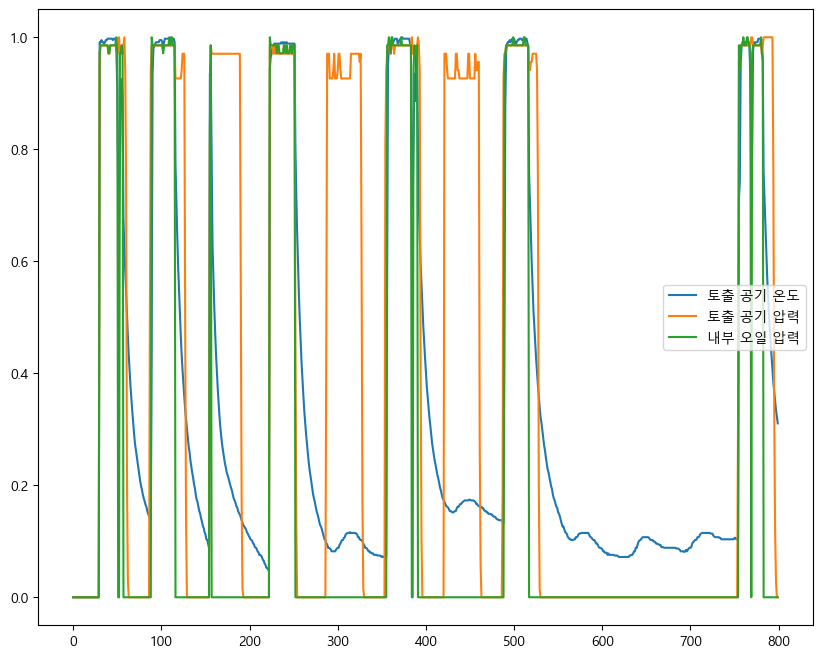

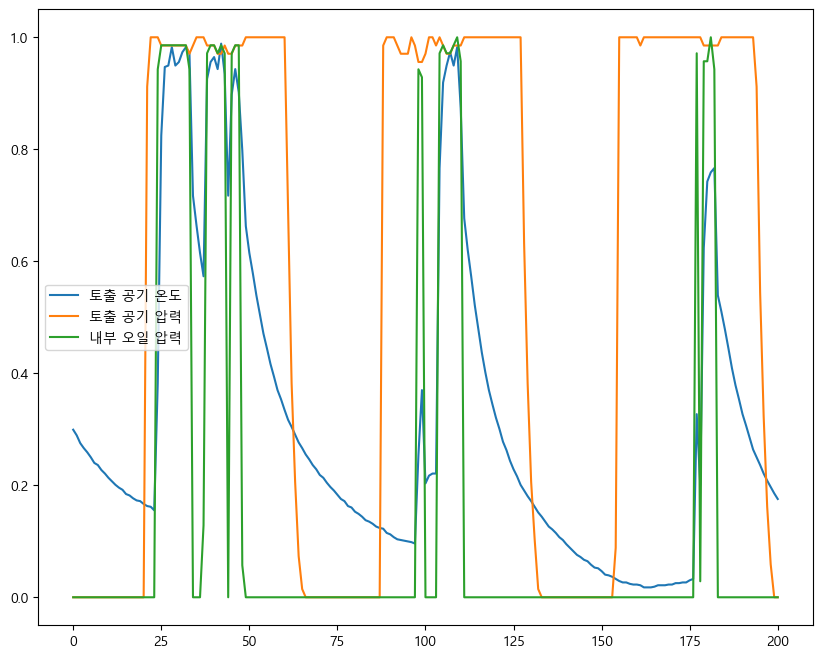

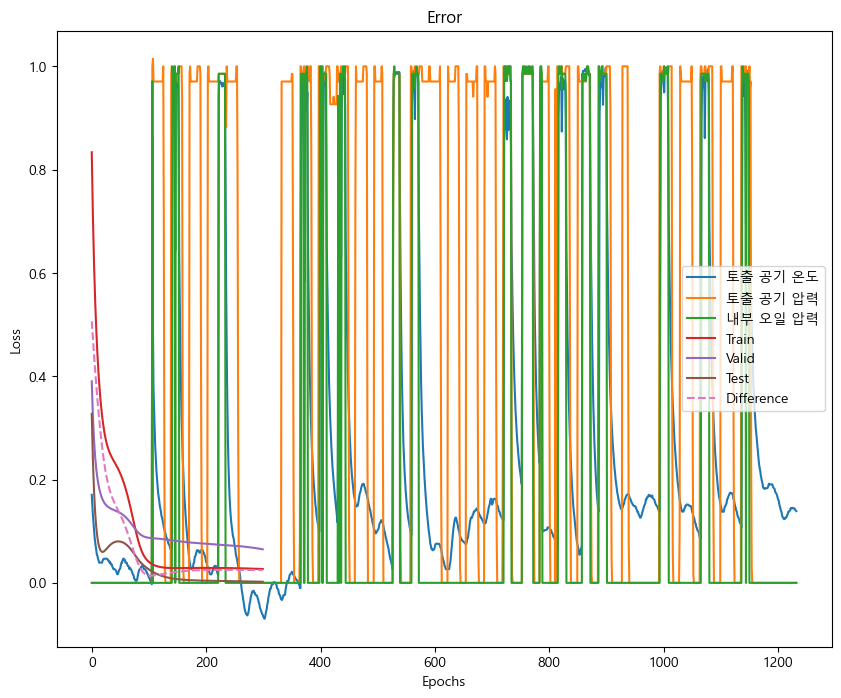

------------------------------------------------------------------------------------------


In [ ]:
input_dim = train_sdata.shape[1]

batch_size = 67
num_epochs = 300
lr = 0.001

model = AutoEncoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer= optim.Adam(model.parameters(),lr = lr)

## model train
model,best_test_loss, train_loss, valid_loss,test_loss = train_model(train_sdata, valid_sdata, test_sdata, model,criterion, optimizer, num_epochs, batch_size)